In [1]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2
from torchvision.models import vgg16 


import numpy as np  
import pandas as pd
import os
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
import collections
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

## Data Exploration And Analysis

In [2]:
csv_path = '../input/coffee-leaves-dataset/dataset.csv'
images_path = '../input/coffee-leaves-dataset/images/images'

coffee_df = pd.read_csv(csv_path)
coffee_df.head()

,id,predominant_stress,miner,rust,phoma,cercospora,severity
0,1,0,0,0,0,0,0
1,2,0,0,0,0,0,0
2,3,0,0,0,0,0,0
3,4,0,0,0,0,0,0
4,5,0,0,0,0,0,0


In [3]:
coffee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747 entries, 0 to 1746
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   id                  1747 non-null   int64
 1   predominant_stress  1747 non-null   int64
 2   miner               1747 non-null   int64
 3   rust                1747 non-null   int64
 4   phoma               1747 non-null   int64
 5   cercospora          1747 non-null   int64
 6   severity            1747 non-null   int64
dtypes: int64(7)
memory usage: 95.7 KB


<AxesSubplot:>

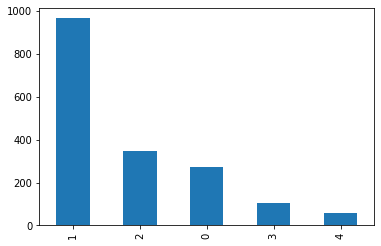

In [4]:
coffee_df['severity'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

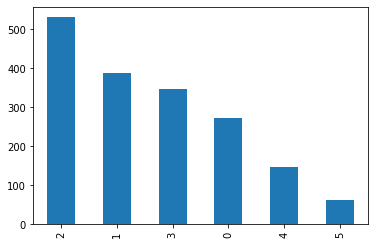

In [5]:
coffee_df['predominant_stress'].value_counts().plot(kind = 'bar')

In [6]:
coffee_df[(coffee_df['miner'] + coffee_df['rust'] + coffee_df['phoma'] + coffee_df['cercospora']) > 1].shape

(372, 7)

**we have total of 372 images with more than one stress present**

In [7]:
coffee_df[coffee_df['predominant_stress'] == 5]

,id,predominant_stress,miner,rust,phoma,cercospora,severity
551,552,5,0,0,1,1,1
607,608,5,0,0,1,0,1
638,639,5,0,0,0,0,0
667,668,5,0,0,0,1,1
670,671,5,0,0,0,0,0
...,...,...,...,...,...,...,...
1714,1715,5,0,1,0,1,1
1721,1722,5,0,1,0,1,1
1722,1723,5,1,0,0,1,1
1730,1731,5,0,1,0,1,2


In [8]:
def get_predominant_stress(miner, rust, phoma, cercospora) :
    stress_lst = [miner, rust, phoma, cercospora]
    predominant_stress = np.argmax(stress_lst) + 1
    return predominant_stress

get_predominant_stress(0,0,1,0)

3

In [9]:
coffee_df.loc[coffee_df['predominant_stress'] == 5, 'predominant_stress'] = coffee_df[coffee_df['predominant_stress'] == 5].apply(lambda x: get_predominant_stress(x['miner'], x['rust'], x['phoma'], x['cercospora']), axis = 1)

In [10]:
# check for 5
coffee_df[coffee_df['predominant_stress'] == 5].shape

(0, 7)

In [11]:
images_path = '../input/coffee-leaves-dataset/images/images'

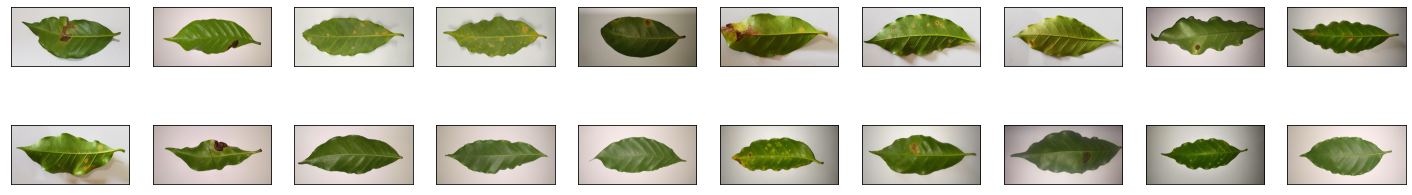

In [12]:
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    random_sample = coffee_df.sample(1)['id'].values[0]
    img_path = os.path.join(images_path, f'{random_sample}.jpg')
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    

## load data and data loader

In [13]:

class ImagesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, coffee_df, img_directory, transforms = None, mode = 'train'):
        
        self.df = coffee_df
        self.img_directory = img_directory
        self.mode = mode
        self.transforms = transforms
        
        
        
        
        self.train, self.test_df = train_test_split(self.df, test_size = 0.1, 
                                                    shuffle = True, stratify = self.df['severity'])
        
        self.train, self.test_df = self.train.reset_index(drop = True), self.test_df.reset_index(drop = True)
        
        self.train_df, self.valid_df = train_test_split(self.train, test_size = 0.1)
 
        self.train_df, self.valid_df = self.train_df.reset_index(drop = True), self.valid_df.reset_index(drop = True) 
        
        self.image_info = self.data_dict()
        
        
        
    def data_dict(self) :
        image_info = collections.defaultdict(dict)
        if self.mode == 'train' :
            data = self.train_df
        elif self.mode == 'validation' :
            data = self.valid_df
        elif self.mode == 'test' :
            data = self.test_df
        else :
            print('Invalid mode')
            
        for index, row in data.iterrows() :
            image_info[index] = {'image_id' : row['id'], 'severity' : row['severity'],
                                'miner' : row['miner'], 'rust' : row['rust'], 
                                'phoma' : row['phoma'], 'cercospora' : row['cercospora'], 
                                 'predominant_stress' : row['predominant_stress']}
            
        return image_info    
        
    def __len__(self):
        return len(self.image_info)

    def __getitem__(self, idx):
        
            
        image_id = self.image_info[idx]['image_id']
        image = cv2.imread(os.path.join(self.img_directory, str(image_id) + '.jpg'))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        miner = self.image_info[idx]['miner']
        rust = self.image_info[idx]['rust']
        phoma = self.image_info[idx]['phoma']
        cercospora = self.image_info[idx]['cercospora']
        severity = self.image_info[idx]['severity']
        predominant_stress  = self.image_info[idx]['predominant_stress']
        
        if self.transforms : 
            image = self.transforms(image)
        
        sample = {'image' : image, 'severity' : severity, 'miner' : miner, 'rust' : rust, 
                 'phoma' : phoma, 'cercospora' : cercospora, 'predominant_stress' : predominant_stress}
        
        return sample

In [14]:
def data_loader(coffee_df, images_path, batch_size = 32) :
    
    train_transforms=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.RandomApply([transforms.RandomRotation(10)], 0.25),
        #transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    val_transforms=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    
    train_image_data = ImagesDataset(coffee_df, images_path, mode = 'train', transforms = train_transforms)
    valid_image_data = ImagesDataset(coffee_df, images_path, mode = 'validation', transforms = val_transforms)
    test_iamge_data = ImagesDataset(coffee_df, images_path, mode = 'test', transforms = val_transforms)
    
    
    num_workers = 0

    train_loader = torch.utils.data.DataLoader(train_image_data, batch_size = batch_size,
                                              num_workers = num_workers)
    validation_loader = torch.utils.data.DataLoader(valid_image_data, batch_size = batch_size,
                                                   num_workers = num_workers)
    test_loader = torch.utils.data.DataLoader(test_iamge_data, batch_size = batch_size, 
                                         num_workers = num_workers)
    
    return train_loader, validation_loader, test_loader

In [15]:
train_loader, validation_loader, test_loader = data_loader(coffee_df, images_path, batch_size = 32)

In [16]:
x = next(iter(train_loader))
# img = x['image'][0]
# plt.imshow(img.numpy().transpose(1,2,0))
print(x['severity'])
print(x['miner'])
print(x['rust'])
print(x['phoma'])
print(x['cercospora'])

tensor([1, 1, 0, 0, 1, 1, 1, 2, 0, 4, 1, 4, 0, 0, 1, 1, 2, 2, 2, 2, 2, 0, 3, 1,
        1, 2, 1, 2, 1, 1, 1, 4])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 0])
tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 1])
tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0])


## Model

In [17]:
class MultiClass_Classifier(nn.Module) :
    def __init__(self) : 
        super().__init__() 
        
        self.base_model = vgg16(pretrained = True).features
        
        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.severity_head = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 5)
        )
        
        self.stress_head = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 5)
        )
        
        self.miner_head = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(), 
            nn.Linear(4096, 1)
        )
        
        self.rust_head = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1)
        )
        
        self.phoma_head = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1)
        )
        
        self.cercospora_head = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1)
        )
        
        
    def forward(self, x) :
        
        x = self.base_model(x)
        x = self.adaptive_avg_pool(x)
        x = x.view(x.shape[0], -1)
        
        # correspond to severity
        out1 = self.severity_head(x)
        
        # correspond to predominant stress
        out2 = self.stress_head(x)
        
        # correspond to stress
        out3 = self.miner_head(x)
        out4 = self.rust_head(x)
        out5 = self.phoma_head(x)
        out6 = self.cercospora_head(x)
        
        output = {'severity' : out1, 'predominant_stress' : out2, 'miner_stress' : out3, 'rust_stress' : out4,
                  'phoma_stress' : out5, 'cercospora_stress' : out6}
        
        return output 
model = MultiClass_Classifier()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

## Train

In [18]:
def train(model, epochs, train_loader, validation_loader, model_chk_path = './model.pth') :
    
    ## optimizer and criterion
    optimizer = optim.SGD(model.parameters(), lr = 0.01)
    multi_class_criterion = nn.CrossEntropyLoss()
    binary_criterion = nn.BCEWithLogitsLoss()
    
    model.to(device)
    
    training_losses = []
    validation_losses = []
    valid_loss_min = np.inf
    
    for e in range(epochs) :
        running_loss = 0
        validation_loss = 0

        model.train()
        i = 0
        for samples in train_loader :

            images = samples['image']
            severity = samples['severity']
            stress = samples['predominant_stress']
            miner = samples['miner'].type(torch.FloatTensor).unsqueeze(1)
            rust = samples['rust'].type(torch.FloatTensor).unsqueeze(1)
            phoma = samples['phoma'].type(torch.FloatTensor).unsqueeze(1)
            cercospora = samples['cercospora'].type(torch.FloatTensor).unsqueeze(1)

            images, severity, stress, miner, rust, phoma, cercospora = images.to(device), severity.to(device), stress.to(device), miner.to(device), rust.to(device), phoma.to(device), cercospora.to(device)

            optimizer.zero_grad()
            output = model(images)
            
            ## prediction
            severity_pred = output['severity']
            stress_pred = output['predominant_stress']
            miner_pred = output['miner_stress']
            rust_pred = output['rust_stress']
            phoma_pred = output['phoma_stress']
            cercospora_pred = output['cercospora_stress']
            
            ## losses
            sev_loss = multi_class_criterion(severity_pred, severity)
            stress_loss = multi_class_criterion(stress_pred, stress)
            miner_loss = binary_criterion(miner_pred, miner)
            rust_loss = binary_criterion(rust_pred, rust)
            phoma_loss = binary_criterion(phoma_pred, phoma)
            cercospora_loss = binary_criterion(cercospora_pred, cercospora)

            total_loss = sev_loss + stress_loss + miner_loss + rust_loss + phoma_loss + cercospora_loss
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()*images.size(0) 
    
        model.eval()
        for samples in validation_loader :

            images = samples['image']
            severity = samples['severity']
            stress = samples['predominant_stress']
            miner = samples['miner'].type(torch.FloatTensor).unsqueeze(1)
            rust = samples['rust'].type(torch.FloatTensor).unsqueeze(1)
            phoma = samples['phoma'].type(torch.FloatTensor).unsqueeze(1)
            cercospora = samples['cercospora'].type(torch.FloatTensor).unsqueeze(1)        

            images, severity, stress, miner, rust, phoma, cercospora = images.to(device), severity.to(device), stress.to(device), miner.to(device), rust.to(device), phoma.to(device), cercospora.to(device)

            output = model(images)

            ## prediction
            severity_pred = output['severity']
            stress_pred = output['predominant_stress']
            miner_pred = output['miner_stress']
            rust_pred = output['rust_stress']
            phoma_pred = output['phoma_stress']
            cercospora_pred = output['cercospora_stress']

            ## losses
            sev_loss = multi_class_criterion(severity_pred, severity)
            stress_loss = multi_class_criterion(stress_pred, stress)
            miner_loss = binary_criterion(miner_pred, miner)
            rust_loss = binary_criterion(rust_pred, rust)
            phoma_loss = binary_criterion(phoma_pred, phoma)
            cercospora_loss = binary_criterion(cercospora_pred, cercospora)

            total_loss = sev_loss + stress_loss + miner_loss + rust_loss + phoma_loss + cercospora_loss

            validation_loss += total_loss.item()*images.size(0)


        train_loss = running_loss/len(train_loader.dataset)
        valid_loss = validation_loss/len(validation_loader.dataset)

        training_losses.append(train_loss)
        validation_losses.append(valid_loss)

        print('Epoch {} /tTraining Loss : {:0.6f} /tValidation Loss : {:0.6f}'.
              format(e+1, train_loss, valid_loss))    


        if valid_loss < valid_loss_min :
            print('Validation Loss Decreased ({:0.6f} --> {:0.6f}).   saving model...'.format(
                  valid_loss_min, valid_loss, torch.save(model.state_dict(), model_chk_path)))

            valid_loss_min = valid_loss
    return model    

In [19]:
## Training
model = train(model = model, epochs = 50, train_loader = train_loader,
              validation_loader = validation_loader, model_chk_path = './model.pth')


Epoch 1 /tTraining Loss : 4.780680 /tValidation Loss : 5.522772
Validation Loss Decreased (inf --> 5.522772).   saving model...
Epoch 2 /tTraining Loss : 3.597858 /tValidation Loss : 3.408618
Validation Loss Decreased (5.522772 --> 3.408618).   saving model...
Epoch 3 /tTraining Loss : 2.371541 /tValidation Loss : 2.101243
Validation Loss Decreased (3.408618 --> 2.101243).   saving model...
Epoch 4 /tTraining Loss : 1.890841 /tValidation Loss : 1.986205
Validation Loss Decreased (2.101243 --> 1.986205).   saving model...
Epoch 5 /tTraining Loss : 1.590973 /tValidation Loss : 2.484642
Epoch 6 /tTraining Loss : 1.442623 /tValidation Loss : 1.502694
Validation Loss Decreased (1.986205 --> 1.502694).   saving model...
Epoch 7 /tTraining Loss : 1.248337 /tValidation Loss : 1.629425
Epoch 8 /tTraining Loss : 1.119479 /tValidation Loss : 1.890351
Epoch 9 /tTraining Loss : 0.972583 /tValidation Loss : 1.354381
Validation Loss Decreased (1.502694 --> 1.354381).   saving model...
Epoch 10 /tTrai

## Load Trained Model

In [20]:
model_chk = './model.pth'
model.load_state_dict(torch.load(model_chk))

<All keys matched successfully>

In [21]:
def prediction_class(lst, threshold) : 
    for i in range(len(lst)) : 
        if lst[i] >= threshold :
            lst[i] = 1
        else :
            lst[i] = 0
    return lst       

In [22]:
def predict(test_loader, model) :
    
    samples_dict = {'severity_lst' : [], 'stress_lst' : [], 'miner_lst' : [], 
                    'rust_lst' : [], 'phoma_lst' : [], 'cercospora_lst' : []}
    prediction_dict = {'severity_prediction' : [], 'stress_prediction' : [], 'miner_prediction' : [],
                       'rust_prediction' : [], 'phoma_prediction' : [], 'cercospora_prediction' : []}
    
    model.to(device)
    
    model.eval()
    for samples in test_loader :

        images = samples['image']
        severity = samples['severity']
        stress = samples['predominant_stress']
        miner = samples['miner'].type(torch.FloatTensor).unsqueeze(1)
        rust = samples['rust'].type(torch.FloatTensor).unsqueeze(1)
        phoma = samples['phoma'].type(torch.FloatTensor).unsqueeze(1)
        cercospora = samples['cercospora'].type(torch.FloatTensor).unsqueeze(1)        


        samples_dict['severity_lst'].extend(severity.numpy())
        samples_dict['stress_lst'].extend(severity.numpy())
        samples_dict['miner_lst'].extend(miner.squeeze(1).numpy())
        samples_dict['rust_lst'].extend(rust.squeeze(1).numpy())
        samples_dict['phoma_lst'].extend(phoma.squeeze(1).numpy())
        samples_dict['cercospora_lst'].extend(cercospora.squeeze(1).numpy())

        images, severity, stress, miner, rust, phoma, cercospora = images.to(device), severity.to(device), stress.to(device), miner.to(device), rust.to(device), phoma.to(device), cercospora.to(device)

        output = model(images)

        ## prediction
        severity_pred = torch.softmax(output['severity'], dim=1)
        _, severity_pred_class = torch.max(severity_pred.data, 1)

        stress_pred = torch.softmax(output['predominant_stress'], dim=1)
        _, stress_pred_class = torch.max(stress_pred.data, 1)
        
        miner_pred = torch.sigmoid(output['miner_stress'])
        miner_pred_class = prediction_class(miner_pred, 0.5)

        rust_pred = torch.sigmoid(output['rust_stress'])
        rust_pred_class = prediction_class(rust_pred, 0.5)

        phoma_pred = torch.sigmoid(output['phoma_stress'])
        phoma_pred_class = prediction_class(phoma_pred, 0.5)

        cercospora_pred = torch.sigmoid(output['cercospora_stress'])
        cercospora_pred_class = prediction_class(cercospora_pred, 0.5)

        prediction_dict['severity_prediction'].extend(severity_pred_class.cpu().detach().squeeze(-1).numpy())
        prediction_dict['stress_prediction'].extend(stress_pred_class.cpu().detach().squeeze(-1).numpy())
        prediction_dict['miner_prediction'].extend(miner_pred_class.cpu().detach().squeeze(1).numpy())
        prediction_dict['rust_prediction'].extend(rust_pred_class.cpu().detach().squeeze(1).numpy())
        prediction_dict ['phoma_prediction'].extend(phoma_pred_class.cpu().detach().squeeze(1).numpy())
        prediction_dict['cercospora_prediction'].extend(cercospora_pred_class.cpu().detach().squeeze(1).numpy())

    
    return samples_dict, prediction_dict
    

In [23]:
samples_dict, prediction_dict = predict(test_loader = test_loader, model = model)

In [24]:
def acc_heatmap_and_cls_report(y_true, y_pred, percentage = False, names= None, title = 'Heatmap') :
    cm = confusion_matrix(y_true, y_pred)
    cm_accuracy = (cm / cm.sum(axis = 0)) * 100
    cls_report = classification_report(y_true, y_pred, target_names = names)
    accuracy = accuracy_score(y_true, y_pred)
    plt.figure(figsize = (12,8))
    
    ax = sns.heatmap(cm_accuracy if percentage else cm, annot=True, cmap='Blues', fmt = '0.2f')
    
    ax.set_title(title);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()
    return cls_report, accuracy

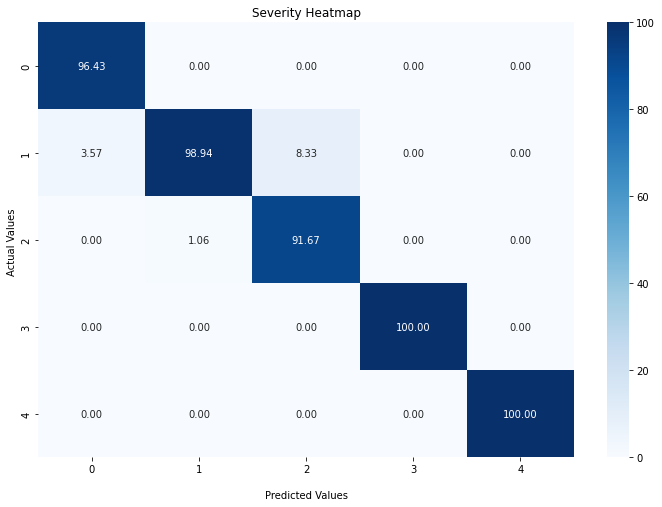

In [25]:
## severity 
names = ['Healthy', 'Very low', 'Low', 'High', 'Very high']
sev_cls_report, sev_accuracy = acc_heatmap_and_cls_report(samples_dict['severity_lst'], prediction_dict['severity_prediction'], 
                                                          percentage = True, names = names, title = 'Severity Heatmap')

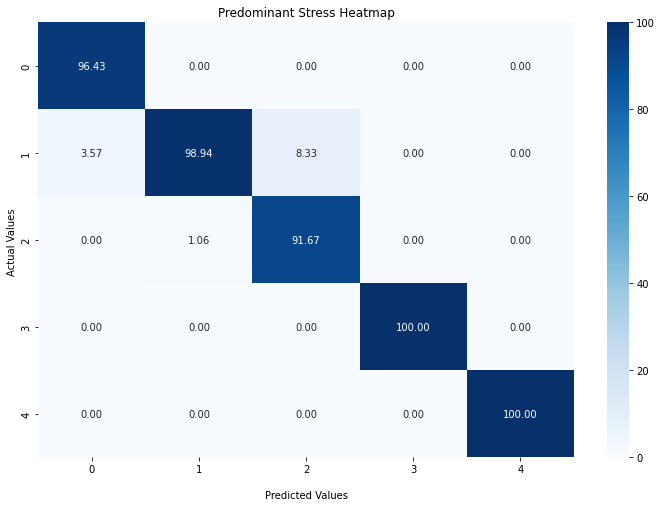

In [26]:
## stress 
stress_cls_report, stress_accuracy = acc_heatmap_and_cls_report(samples_dict['severity_lst'], prediction_dict['severity_prediction'], 
                                                          percentage = True, title = 'Predominant Stress Heatmap')

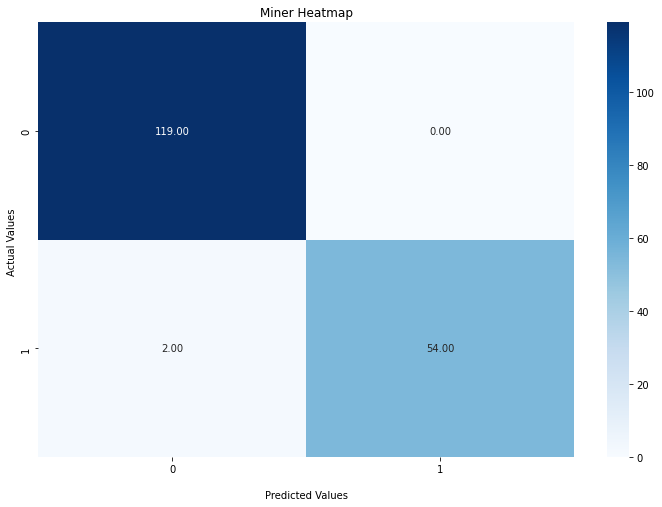

In [27]:
## miner
miner_cls_report, miner_accuracy = acc_heatmap_and_cls_report(samples_dict['miner_lst'],
                                                              prediction_dict['miner_prediction'], title = 'Miner Heatmap')

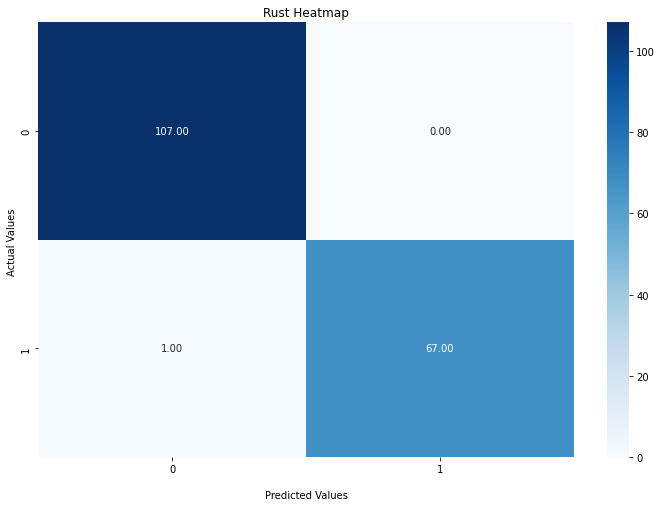

In [28]:
## rust
rust_cls_report, rust_accuracy = acc_heatmap_and_cls_report(samples_dict['rust_lst'], 
                                                            prediction_dict['rust_prediction'], title = 'Rust Heatmap')

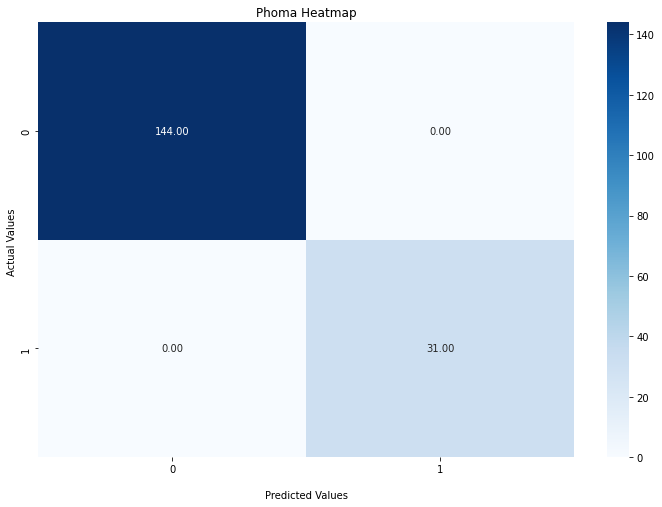

In [29]:
## phoma
phoma_cls_report, phoma_accuracy = acc_heatmap_and_cls_report(samples_dict['phoma_lst'],
                                                              prediction_dict['phoma_prediction'], title = 'Phoma Heatmap')

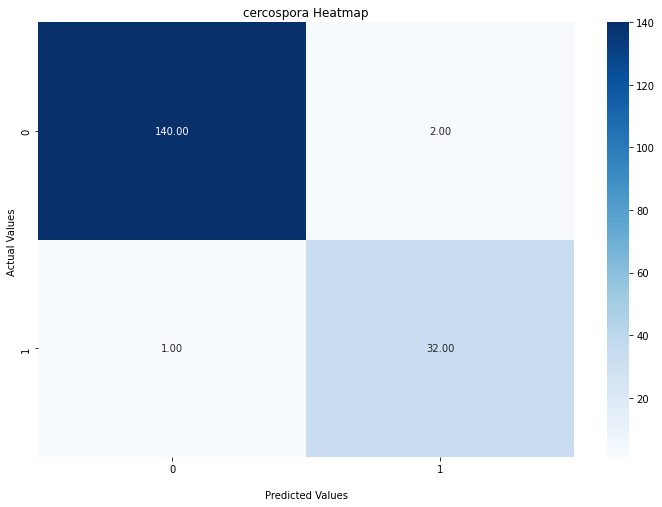

In [30]:
## cercosposa
cercosposa_cls_report, cercospora_accuracy = acc_heatmap_and_cls_report(samples_dict['cercospora_lst'], 
                                                                        prediction_dict['cercospora_prediction'], 
                                                                       title = 'cercospora Heatmap')

## All Accuracies

In [31]:
accuracy_df = pd.DataFrame({'prediction_Name' : ['Severity', 'predominant_stress', 'Miner', 'Rust', 'Phoma', 'Cercosposa'],
                           'accuracy' : [sev_accuracy*100, stress_accuracy*100, miner_accuracy*100, 
                                         rust_accuracy*100, phoma_accuracy*100, cercospora_accuracy*100]})
accuracy_df

,prediction_Name,accuracy
0,Severity,97.142857
1,predominant_stress,97.142857
2,Miner,98.857143
3,Rust,99.428571
4,Phoma,100.000000
5,Cercosposa,98.285714


## Prediction of all dataset and saving the csv

In [32]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

all_images = os.listdir(images_path)

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [34]:
img_id = []
severity = []
stress = []
miner = []
rust = []
phoma = []
cercospora = []

for file in all_images :
    id_ = int(file.split('.')[0])
    img = cv2.imread(os.path.join(images_path, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ## transforms
    img = transform(img)
    img = img.unsqueeze(0).to(device)
    ## prediction
    output = model(img)
    
    severity_pred = torch.softmax(output['severity'], dim=1)
    _, severity_pred_class = torch.max(severity_pred.data, 1)
    
    stress_pred = torch.softmax(output['predominant_stress'], dim=1)
    _, stress_pred_class = torch.max(stress_pred.data, 1)
    
    miner_pred = torch.sigmoid(output['miner_stress'])
    miner_pred_class = prediction_class(miner_pred, 0.5)

    rust_pred = torch.sigmoid(output['rust_stress'])
    rust_pred_class = prediction_class(rust_pred, 0.5)

    phoma_pred = torch.sigmoid(output['phoma_stress'])
    phoma_pred_class = prediction_class(phoma_pred, 0.5)

    cercospora_pred = torch.sigmoid(output['cercospora_stress'])
    cercospora_pred_class = prediction_class(cercospora_pred, 0.5)
    
    img_id.append((id_))
    severity.append(severity_pred_class.cpu().detach().squeeze(-1).numpy())
    stress.append(stress_pred_class.cpu().detach().squeeze(-1).numpy())
    miner.extend(miner_pred_class.cpu().detach().squeeze(1).numpy())
    rust.extend(rust_pred_class.cpu().detach().squeeze(1).numpy())
    phoma.extend(phoma_pred_class.cpu().detach().squeeze(1).numpy())
    cercospora.extend(cercospora_pred_class.cpu().detach().squeeze(1).numpy())

In [35]:
final_submission = pd.DataFrame({'id' : img_id, 'miner' : miner, 'rust' : rust, 'phoma' : phoma, 'cercospora' : cercospora,
                               'severity' : severity}) 
final_submission.to_csv('final_submission.csv', index = False)

In [36]:
final_submission.shape

(1747, 6)

In [37]:
final_submission

,id,miner,rust,phoma,cercospora,severity
0,1269,0.0,1.0,0.0,0.0,1
1,623,1.0,1.0,0.0,0.0,1
2,764,0.0,1.0,0.0,0.0,1
3,1700,0.0,0.0,0.0,1.0,2
4,1075,1.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...
1742,1201,0.0,0.0,0.0,0.0,0
1743,147,0.0,1.0,0.0,0.0,1
1744,921,0.0,0.0,0.0,0.0,0
1745,728,1.0,0.0,0.0,0.0,1
